In [1]:
import cv2
import numpy as np
from superpoint.datasets.synthetic_shapes import SyntheticShapes
from superpoint.datasets import get_dataset
from notebooks.utils import plot_imgs
from superpoint.models.classical_detectors_descriptors import classical_detector_descriptor
from superpoint.settings import EXPER_PATH
from pathlib import Path
import tensorflow as tf

%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/xm-ailab-000/.conda/envs/minutiae/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/xm-ailab-000/.conda/envs/minutiae/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/xm-ailab-000/.conda/envs/minutiae/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/xm-ailab-000/.conda/envs/

In [2]:
config = {
    'data':
    {'name': 'finger',
    'cache_in_memory': 'false',
    'validation_size': 100}
}
dataset = get_dataset(config['data']['name'])(**config['data'])
data = dataset.get_test_set()


Instructions for updating:
Use `tf.cast` instead.

Instructions for updating:
Use `tf.cast` instead.


INFO:tensorflow:Caching data, fist access will take some time.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
INFO:tensorflow:Caching data, fist access will take some time.
INFO:tensorflow:Caching data, fist access will take some time.



In [3]:
def harris(img):
    return cv2.cornerHarris(img, 8, 3, 0.05)
def shi(img):
    detections = np.zeros_like(img, np.float)
    thresh = np.linspace(0.0001, 1, 100, endpoint=False)
    for t in thresh:
        corners = cv2.goodFeaturesToTrack(img, 100, t, 5)
        if corners is not None:
            corners = corners.astype(np.int)
            detections[(corners[:, 0, 1], corners[:, 0, 0])] = t
    return detections
def fast(img):
    detector = cv2.FastFeatureDetector_create(10)
    corners = detector.detect(img)
    detections = np.zeros_like(img, np.float)
    for c in corners:
        detections[tuple(np.flip(np.int0(c.pt),0))] = c.response
    return detections

In [4]:
def sift(image):
    sift_points, sift_desc = classical_detector_descriptor(image, **{'method': 'sift'})
    return sift_points

def orb(image):
    orb_points, orb_desc = classical_detector_descriptor(image, **{'method': 'orb'})
    return orb_points

In [5]:
weights_names = ['magic-point_synth', 'magic-point_finger', 'superpoint_finger'] 
weights_root_dir = Path(EXPER_PATH, 'saved_models')

model_type = ['magicpoint' if 'magic' in w else 'superpoint' for w in weights_names]
weights_names = [Path(weights_root_dir, w) for w in weights_names]

def model_predict(img, model_type, weights_name):
    weights_dir = Path(weights_root_dir, weights_name)
    graph = tf.Graph()
    img = np.expand_dims(img, 2)
    with tf.Session(graph=graph) as sess:
        tf.saved_model.loader.load(sess,
                                    [tf.saved_model.tag_constants.SERVING],
                                    str(weights_dir))

        input_img_tensor = graph.get_tensor_by_name(f'{model_type}/image:0')
        output_prob_nms_tensor = graph.get_tensor_by_name(f'{model_type}/prob_nms:0')


        out1 = sess.run([output_prob_nms_tensor],
                            feed_dict={input_img_tensor: np.expand_dims(img, 0)})
        keypoint_map1 = np.squeeze(out1[0])
    return   keypoint_map1
        



In [6]:
def disp(img):
    img = cv2.dilate(img, None)
    return img/np.max(img)

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /home/xm-ailab-000/sen/SuperPoint/experiments/saved_models/magic-point_synth/variables/variables
INFO:tensorflow:Restoring parameters from /home/xm-ailab-000/sen/SuperPoint/experiments/saved_models/magic-point_finger/variables/variables
INFO:tensorflow:Restoring parameters from /home/xm-ailab-000/sen/SuperPoint/experiments/saved_models/superpoint_finger/variables/variables
INFO:tensorflow:Restoring parameters from /home/xm-ailab-000/sen/SuperPoint/experiments/saved_models/magic-point_synth/variables/variables
INFO:tensorflow:Restoring parameters from /home/xm-ailab-000/sen/SuperPoint/experiments/saved_models/magic-

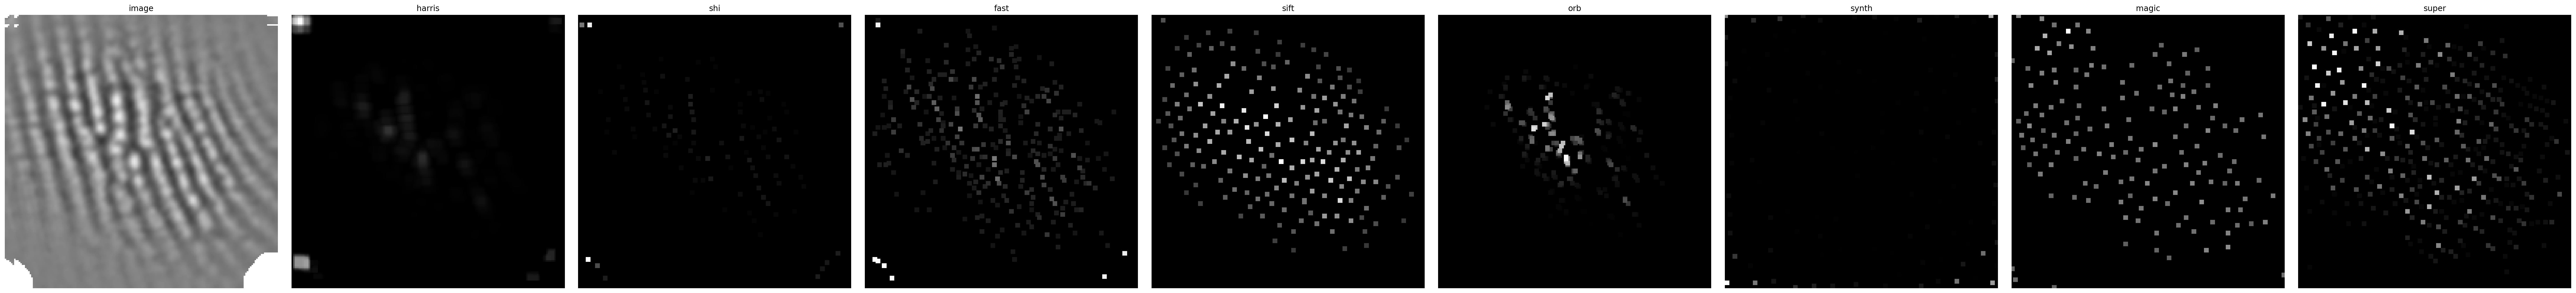

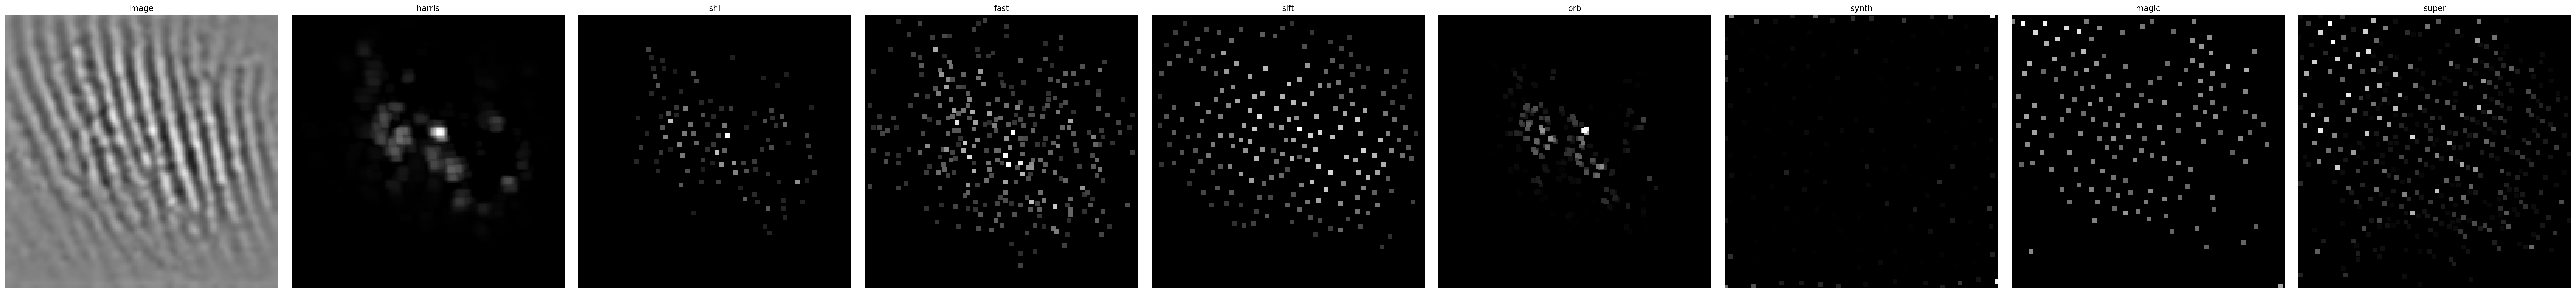

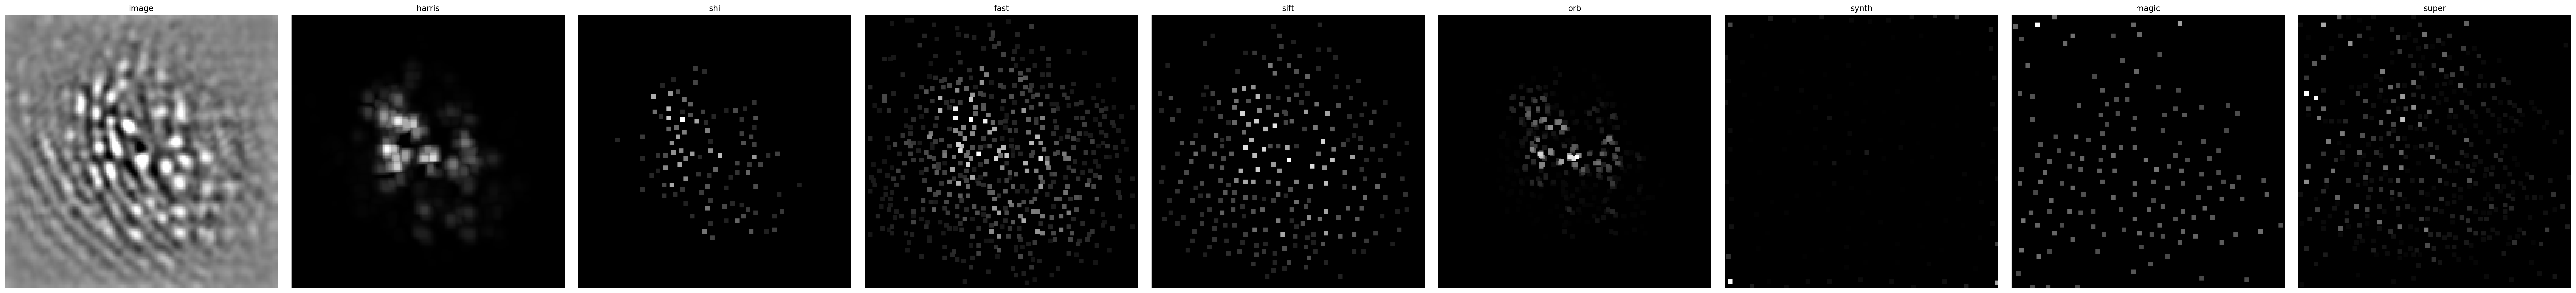

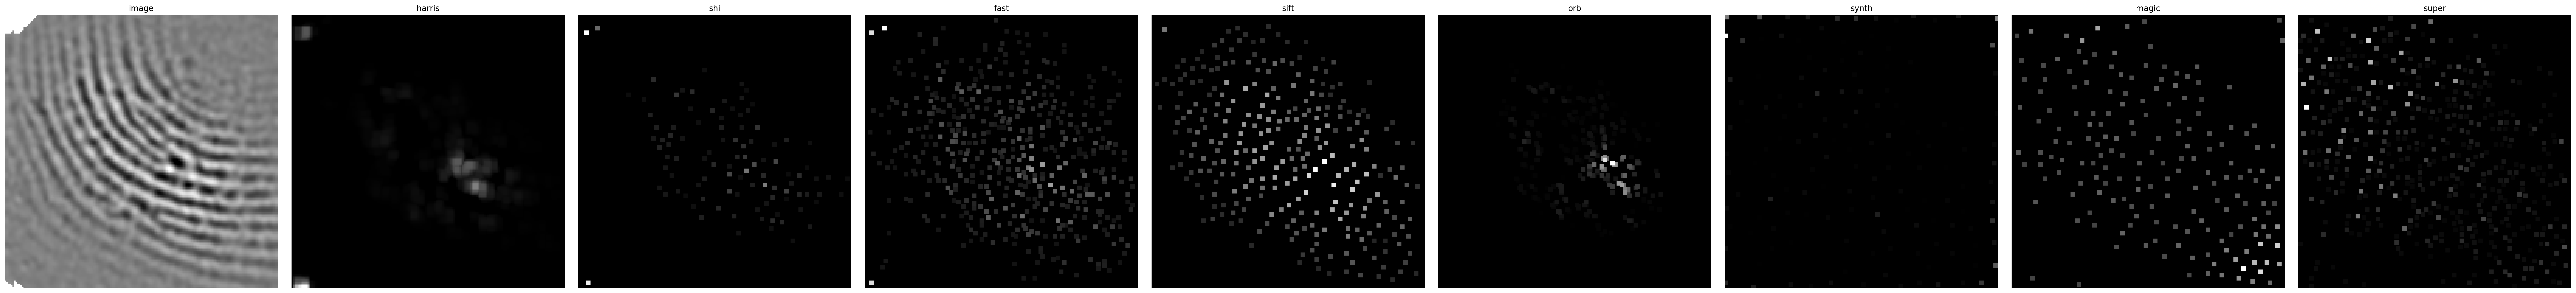

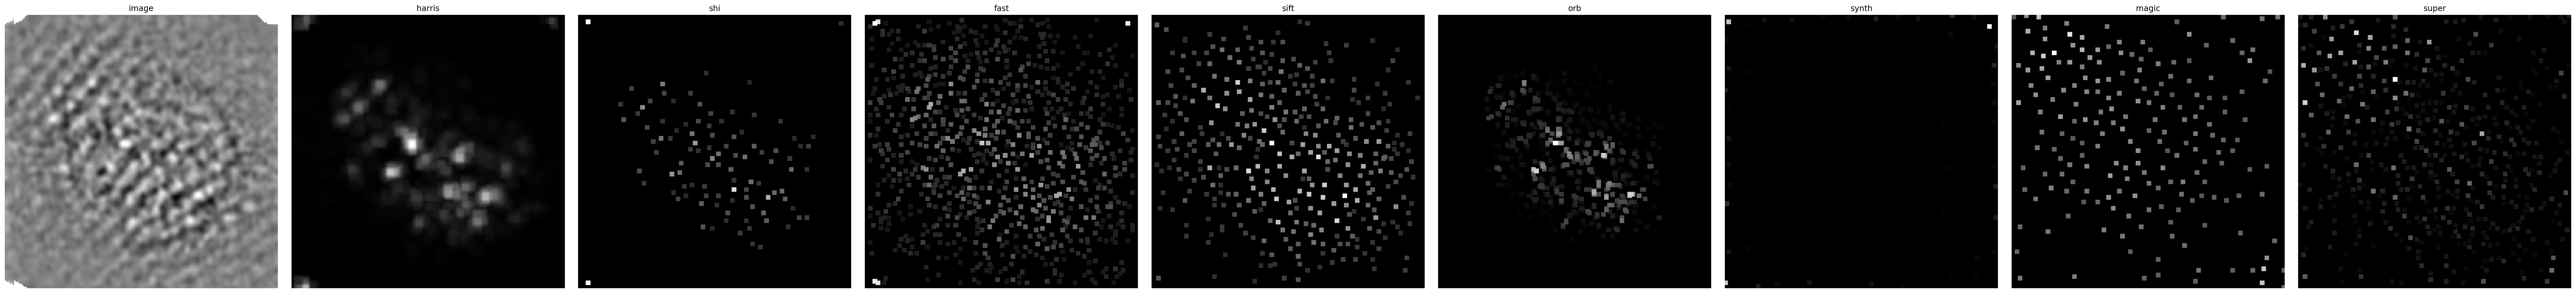

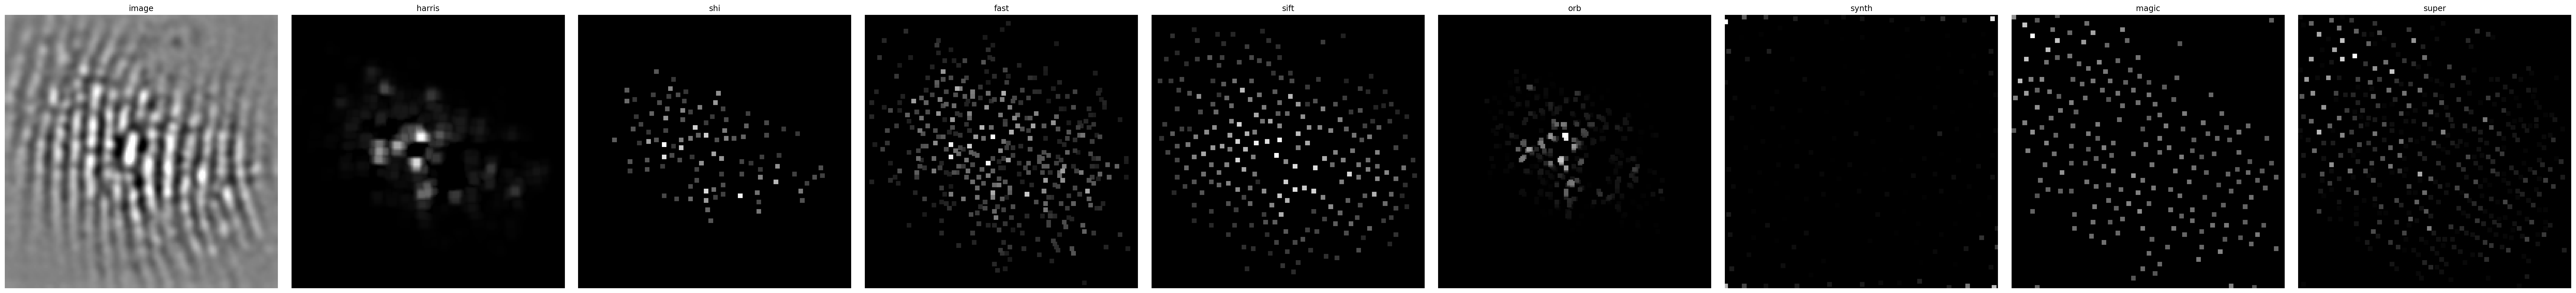

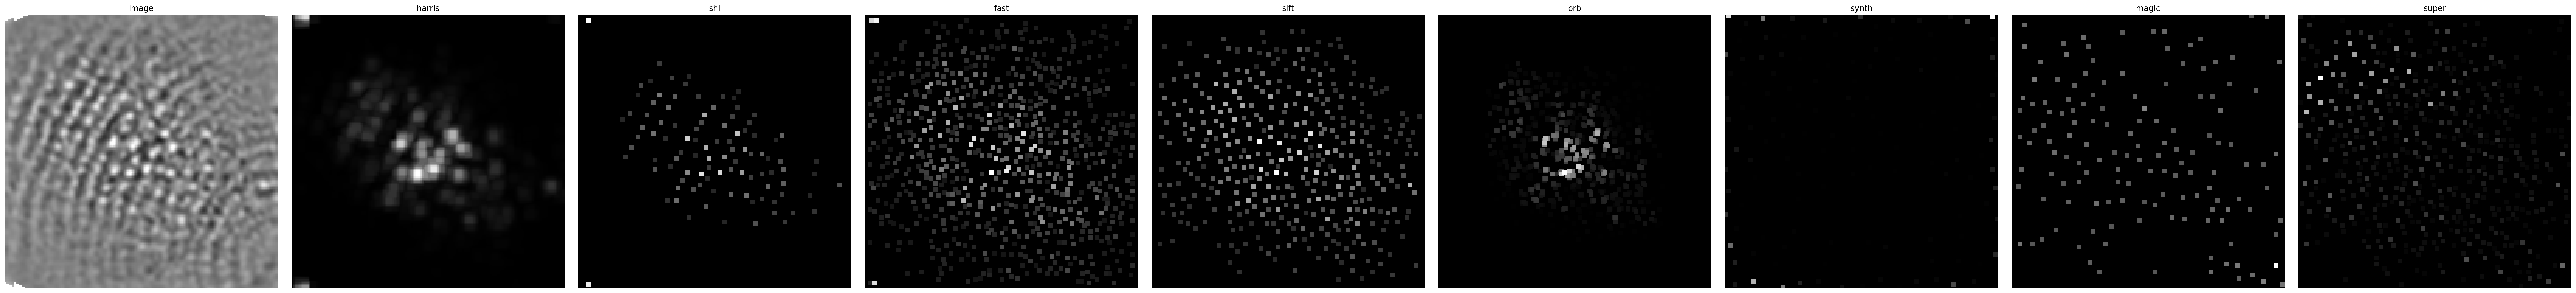

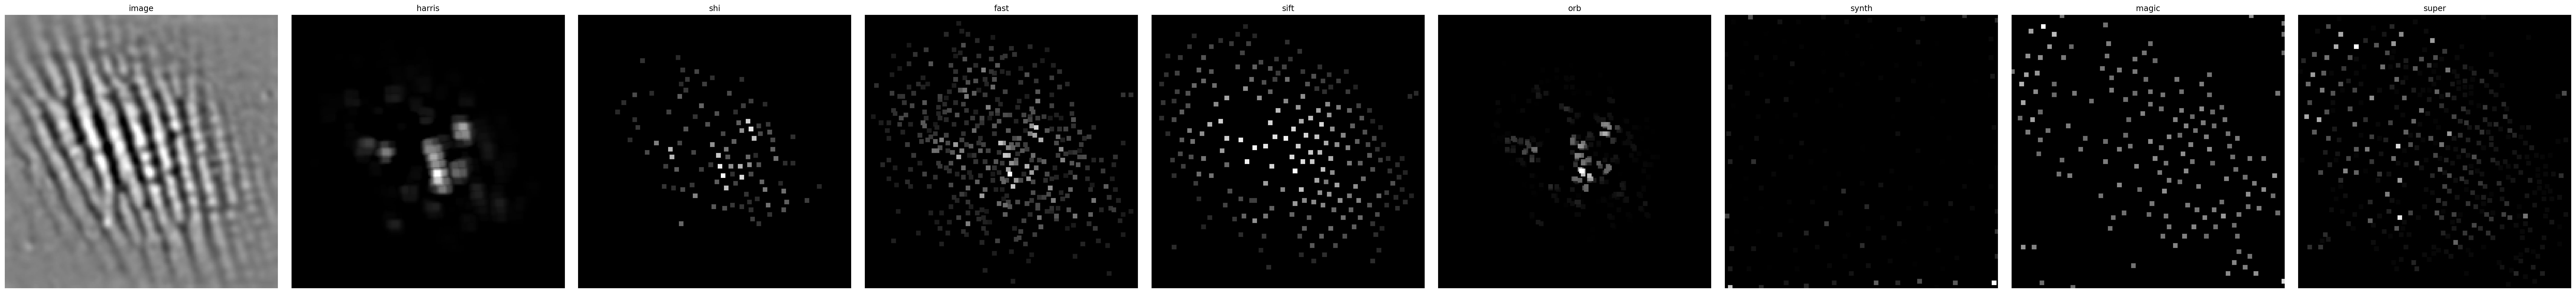

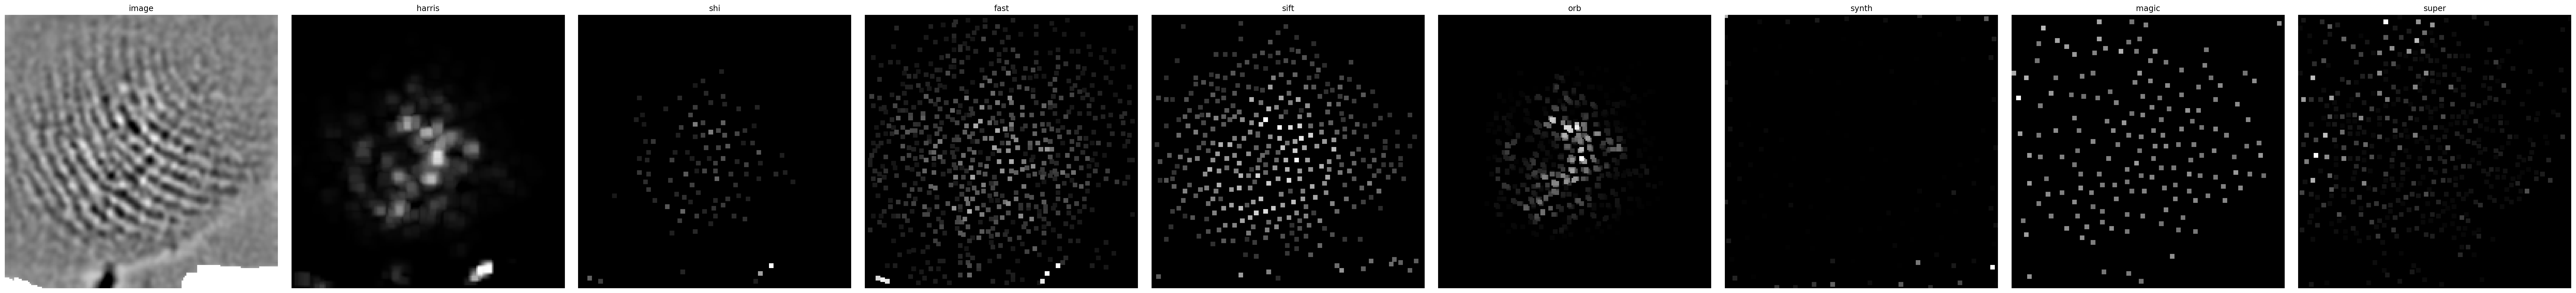

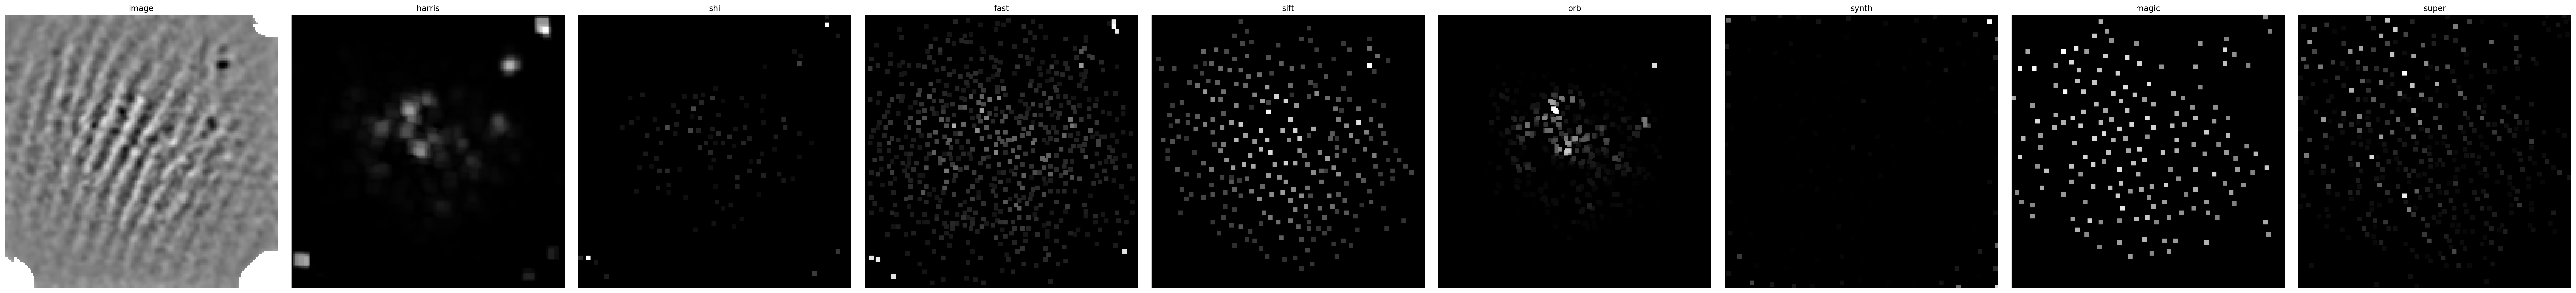

In [7]:
for i in range(10):
    d = next(data)
    im = d['image'][..., 0].astype(np.uint8)
    synth = model_predict(im, model_type[0], weights_names[0])
    magic = model_predict(im, model_type[1], weights_names[1])
    super_f = model_predict(im, model_type[2], weights_names[2])
    plot_imgs([im/255., disp(harris(im)), disp(shi(im)), disp(fast(im)), disp(sift(im)), disp(orb(im)), disp(synth), disp(magic), disp(super_f) ],
     titles=['image','harris', 'shi', 'fast', 'sift', 'orb', 'synth','magic', 'super'], cmap='gray', dpi=200)